# Predict media from taxa

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
import umap

import os
DATA_DIR = "~/Desktop/code/data/"

In [2]:
data_df = pd.read_csv(os.path.join(DATA_DIR, "media2ec-explode.csv"), low_memory=False)

data_df = data_df.dropna(subset='component_id', how='any')
data_df['component_id'] = data_df['component_id'].astype(int)

data_df = data_df[["taxon_id", "media_id", "component_id"]]\
    .value_counts()\
    .reset_index()

data_df = data_df.pivot(
    index=["taxon_id", "media_id"],
    columns="component_id",
    values="count"
)
data_df = data_df.fillna(0.0).reset_index()
data_df.head()

component_id,taxon_id,media_id,4,18,33,37,46,47,56,60,...,337,430,497,498,506,616,688,754,1353,1359
0,100,J349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003997,J1052,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100468,J13,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1005740,J940,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1005944,J346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

### Strategy for splitting

In [3]:
TARGET_VAR = "media_id"
RANDOM_SEED = 666
UMAP_METRIC = "euclidean"
UMAP_SEED = 42

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_df.drop(["taxon_id", "media_id"], axis=1),
    data_df[TARGET_VAR],
    test_size=0.2,
    random_state=RANDOM_SEED
)

### Dimensionality reduction

In [5]:
# Define the pipeline
reducer = umap.UMAP(
        metric="euclidean",
        n_epochs=500,
        random_state=RANDOM_SEED,
        n_jobs=1,
        n_neighbors=5,
        n_components=5,
        min_dist=0.4
    )

reduced = reducer.fit_transform(X_train)
reduced_df = pd.DataFrame(reduced, columns=[f"Component {i+1}" for i in range(reduced.shape[1])])

reduced_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5
0,17.562004,3.846345,15.447453,9.840640,2.074880
1,12.171132,-4.933949,-0.648737,8.836231,3.086252
2,8.962107,3.972637,6.885884,1.353348,4.090684
3,1.656117,16.308117,4.628855,5.379225,5.739601
4,8.840848,3.840206,6.932928,1.204266,4.028773


### Clustering

In [6]:
# Silhouette coefficient method
from sklearn.metrics import silhouette_score

# Set variables
X = reduced
y = TARGET_VAR
clusters = []

# Test a range of clusters for their silhouette coefficients
for n_cluster in range(2, 20):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    clusters.append({'n_clusters': n_cluster, 'coefficient': sil_coeff})

# Select the maximum coefficient
clusters = pd.DataFrame(clusters)
c = clusters.iloc[clusters["coefficient"].argmax()]["n_clusters"]
s = clusters["coefficient"].max()
n = int(c)

print("{} clusters returns a maximum Silhouette Coefficient of {}".format(n, s))

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(
c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: 

15 clusters returns a maximum Silhouette Coefficient of 0.7919903993606567


c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


In [7]:
cluster = KMeans(
    n_clusters=n,
    random_state=RANDOM_SEED
)
reduced_df["Cluster"] = cluster.fit_predict(reduced_df.values)
reduced_df["Cluster"] = reduced_df["Cluster"].astype(str)

c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


In [8]:
# Add ID columns
reduced_df[["taxon_id", "media_id"]] = \
    data_df.loc[X_train.index, ["taxon_id", "media_id"]].values

reduced_df

,Component 1,Component 2,Component 3,Component 4,Component 5,Cluster,taxon_id,media_id
0,17.562004,3.846345,15.447453,9.840640,2.074880,3,"[{'NCBI tax id': 2666142, 'Matching level': 's...",J574
1,12.171132,-4.933949,-0.648737,8.836231,3.086252,4,160826,621a
2,8.962107,3.972637,6.885884,1.353348,4.090684,11,392717,J118
3,1.656117,16.308117,4.628855,5.379225,5.739601,1,2662397,J42
4,8.840848,3.840206,6.932928,1.204266,4.028773,11,296745,J557
...,...,...,...,...,...,...,...,...
2601,12.453756,-4.993497,-0.468073,9.109997,2.908635,4,1096779,J25
2602,8.499832,3.416436,6.854227,1.232787,4.018574,11,"[{'NCBI tax id': 1423716, 'Matching level': 's...",J13
2603,10.311670,-0.674405,3.239191,7.071715,2.459418,4,43767,J22
2604,8.556709,3.473586,6.973616,1.144478,4.097568,11,426114,35a


In [9]:
reduced_df.to_csv(os.path.join(DATA_DIR, "comp-model.csv"), index=False)

#### Visualise the results

In [10]:
# Plot the training points
fig = px.scatter(
    data_frame = reduced_df,
    x = "Component 1",
    y = "Component 2",
    color = "Cluster",
    hover_data = ["taxon_id", "media_id"],
    opacity = 0.3
) 

fig.update_layout(
    title="Media Clusters",
    template="plotly_white"
)

fig.show()

#### Create new column from clusters

In [11]:
y_train = cluster.predict(reducer.transform(X_train))
y_test = cluster.predict(reducer.transform(X_test))

y_train

array([ 3,  4, 11, ...,  4, 11,  1])

### Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=666)

### Performance

#### Metrics

In [13]:
y_pred = model.predict(X_test)

report = classification_report(
    y_true=y_test,
    y_pred=y_pred,
    zero_division="warn"
)

print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.92      0.96        39
           2       1.00      0.97      0.99        36
           3       1.00      1.00      1.00        28
           4       0.96      1.00      0.98        24
           5       0.96      1.00      0.98        26
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        24
           8       1.00      0.70      0.82        10
           9       1.00      1.00      1.00        24
          10       0.96      1.00      0.98        79
          11       0.99      1.00      1.00       316
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00        26
          14       1.00      1.00      1.00         1

    accuracy                           0.99       652
   macro avg       0.99      0.97      0.98       652
weighted avg       0.99   

In [14]:
from sklearn import metrics

# TODO: get PR-REC AUC score
# TODO: plot both ROC and PR-REC curves
roc_score = metrics.roc_auc_score(
    y_true=y_test,
    y_score=model.predict_proba(X_test),
    average="weighted",
    multi_class="ovo"
)

print("ROC AUC score:", roc_score)

ROC AUC score: 0.9998823749523884


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [16]:
# Binarize classes
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_train_bin.shape[1]

In [17]:
# OvR classification
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True))
classifier.fit(X_train, y_train_bin)

OneVsRestClassifier(estimator=SVC(kernel='linear', probability=True))

In [18]:
# Predict probabilities
y_score = classifier.decision_function(X_test)

In [19]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Example unique classes across train and test sets
all_classes = np.unique(np.concatenate([y_train, y_test]))  # 96 classes
test_classes = np.unique(y_test)  # 6 classes

# Find the indices of test classes in the full set of classes
relevant_indices = [np.where(all_classes == cls)[0][0] for cls in test_classes]

# Ensure the binarized test set only includes the test classes
y_test_bin = label_binarize(y_test, classes=test_classes)

# Subset y_score to the relevant indices (only the columns corresponding to the test classes)
y_score_subset = y_score[:, relevant_indices]

# Now, calculate ROC curves for each relevant class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test_bin.shape[1]):  # 6 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_subset[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Optionally, print or plot the ROC curves here


In [20]:
print(f"y_test_bin shape: {y_test_bin.shape}")  # Expected shape: (n_samples, 6)
print(f"y_score shape: {y_score.shape}")        # Expected shape: (n_samples, 96)

# Check that the number of classes in test matches the number you are evaluating
assert y_test_bin.shape[1] == len(relevant_indices), "Mismatch between test classes and relevant predictions!"

y_test_bin shape: (652, 15)
y_score shape: (652, 15)


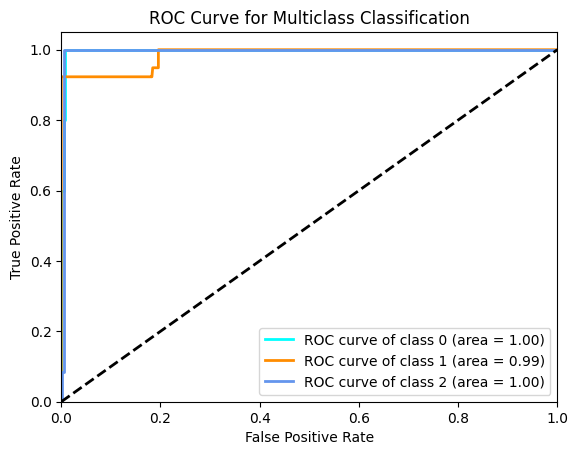

In [21]:
# Plot
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()